# Seminario B: Programación en Paralelo Proyecto Final
## Simulación de Datos para modelos de aprendizaje automático 
### Pruebas de Tiempo

Profesor: Miguel Ángel Pérez León<br>
Ayudante: Iván Coss Calderón<br>
Alumno: Gerardo Martínez Ramos

In [1]:
#importar bibliotecas
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
import scipy.stats as st
import statsmodels as sm
from scipy.stats._continuous_distns import _distn_names # lista de todas las ditribuciones de scipy
import matplotlib
import matplotlib.pyplot as plt
import math
import warnings
import concurrent.futures

In [2]:
# Variables globales

# Configuración para el Notebook
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')
%matplotlib inline

# Lista de distribuciones
global DISTRIBUTIONS, x_value, y_value, data_value

#Lista de todas las distribuciones disponibles en scipy
DISTRIBUTIONS =  [st.ksone,st.kstwobign, st.norm, st.alpha, st.anglit, st.arcsine, st.beta,
 st.betaprime, st.bradford, st.burr, st.burr12, st.fisk, st.cauchy, st.chi,
 st.chi2, st.cosine, st.dgamma, st.dweibull, st.expon, st.exponnorm, st.exponweib,
 st.exponpow, st.fatiguelife, st.foldcauchy, st.f, st.foldnorm, st.weibull_min, st.weibull_max,
 st.frechet_r, st.frechet_l, st.genlogistic, st.genpareto, st.genexpon, st.genextreme, st.gamma,
 st.erlang, st.gengamma, st.genhalflogistic, st.gompertz, st.gumbel_r, st.gumbel_l, st.halfcauchy,
 st.halflogistic, st.halfnorm, st.hypsecant, st.gausshyper, st.invgamma, st.invgauss, st.geninvgauss,
 st.norminvgauss, st.invweibull, st.johnsonsb, st.johnsonsu, st.laplace, st.levy, st.levy_l, st.levy_stable,
 st.logistic, st.loggamma, st.loglaplace, st.lognorm, st.gilbrat, st.maxwell, st.mielke, st.kappa4, st.kappa3,
 st.moyal, st.nakagami, st.ncx2, st.ncf, st.t, st.nct, st.pareto, st.lomax, st.pearson3, st.powerlaw,
 st.powerlognorm, st.powernorm, st.rdist, st.rayleigh, st.loguniform, st.reciprocal, st.rice, st.recipinvgauss,
 st.semicircular, st.skewnorm, st.trapz, st.triang, st.truncexpon, st.truncnorm, st.tukeylambda, st.uniform,
 st.vonmises, st.vonmises_line, st.wald, st.wrapcauchy, st.gennorm, st.halfgennorm, st.crystalball, st.argus]

# semilla para números aleatorios
np.random.seed(0) 

## 0. Funciones Auxiliares

In [3]:
# Funciones Auxiliares.
def split_list(x):
    """Función que divide en 5 partes iguales la lista de distribuciones"""
    aux = []
    ini = 0
    tam = 20
    fin = ini + tam
    while fin <= 100:
        aux.append(x[ini:fin])
        ini = fin
        fin = fin + tam
    return aux   
    
def parallelizable_job(distributions):
    """Función que ajusta cada distribución de la lista recibida a los datos"""
    
    global x_value, y_value, data_value
    best_distribution = st.norm  # Inicializamos con una distribución normal
    best_params = (0.0, 1.0)
    best_sse = np.inf            # inicializa el error SSE en infinito positivo.

    # Estima los parámetros de distribución con base en los datos. 
    for distribution in distributions:

        # Intenta ajustar cada distribución
        try:
            # Ignoramos warnings de datos a los que no se les puede ajustar una distribución particular-
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # Ajusta la distribución a los datos
                params = distribution.fit(data_value)

                # Separa los parámetros de la distribución
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calcula la función de distribución de probabilidad y calcula el SSE respecto a los datos.
                pdf = distribution.pdf(x_value, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y_value - pdf, 2.0))
                
                # Actualizamos el mejor SSE en caso de ser necesario.
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse
        except Exception as e:
            print(f"Exceptions {e}")
    return (best_distribution.name, best_params, best_sse)

def best_fit_distribution(data, bins, parallel=False):
    """Función que devuelve la distribución de probabilidad
    que mejor se ajusta a un conjunto de datos."""
    try:
        y, x = np.histogram(data, bins=bins, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0 # Determina el punto medio de cada intervalo. 
        
        # Definimos las variables globales (para que todos los procesos puedan acceder a estas)
        global x_value, y_value, data_value, results, DISTRIBUTIONS
        x_value = x
        y_value = y
        data_value = data
        results = []
        distributions = DISTRIBUTIONS

        if parallel:        
            split_dist = split_list(distributions)
            with concurrent.futures.ProcessPoolExecutor() as executor: # ThreadPoolExecutor, GIL 
                for dist_list, result in zip(split_dist, executor.map(parallelizable_job, split_dist)):
                    results.append(result) # es seguro con threads/ procesos
            return min(results, key = lambda t: t[2])
        else:
            return parallelizable_job(distributions)
    except Exception as e:
        pass#print(f"Exception {e}")#print(f"{traceback.format_exc()}")
        
def make_pdf(dist, params, size=10000):
    """Genera la función de densidad de probabilidad de una distribución recibida como parámetro."""
    
    # Separamos los parámetros
    arg = params[:-2]  # todo excepto las últimas dos posiciones (varianza, grados de libertad, etc.)
    loc = params[-2]   # penúltimo parámetro
    scale = params[-1] # último parámetro

    # Determinar puntos de inicio y fin para la distribución recibida como parámetro.
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Calcula la función de densidad de prob. y la convierte a un objeto pd.Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def best_pdf(data, bins, parallel=False):
    """Función que devuelve la distribución que mejor se ajusta a los datos recibidos como 
    parámetro.
    
    Argumentos:
    data     -- datos a los que se les ajustará una distribución (pd.Series)
    bins     -- número de contenedores en los que se repartirán los datos. (min 10, max 25)
    parallel -- especfica si la ejecución será en paralelo
    """
    num_bins = bins
    
    if parallel:
        best_fit_name, best_fit_params, sse = best_fit_distribution(data, num_bins, parallel=True)
        best_dist = getattr(st, best_fit_name)
    else:
        best_fit_name, best_fit_params,  sse = best_fit_distribution(data, num_bins, parallel=False)
        best_dist = getattr(st, best_fit_name)

    # Construye la función de densidad de probabilidad.
    pdf = make_pdf(best_dist, best_fit_params, size=len(data))

    # Grafica la segunda figura para mostrar el mejor ajuste.
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=num_bins, density=True, alpha=0.5, label='Datos', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_title(u'Distribución que mejor se ajusta a los datos\n' + dist_str + u'  SSE:={0:.7g}'.format(sse))
    ax.set_xlabel('Datos')
    ax.set_ylabel('Frecuencia')

## 1. Ejecución

In [51]:
normal = ('Normal', np.random.normal(0.0, 2.0, 300))           
chisquare = ('Chisquare', np.random.chisquare(2, 300))       
exponencial = ('Exponencial', np.random.exponential(0.005, 300)) 
logistica = ('Logistica', np.random.logistic(0.0,1.0,300)) 

In [52]:
df = pd.DataFrame( data = exponencial[1])
df.columns = ['col1']

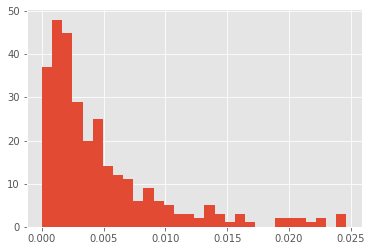

In [57]:
df.col1.hist(bins=30)

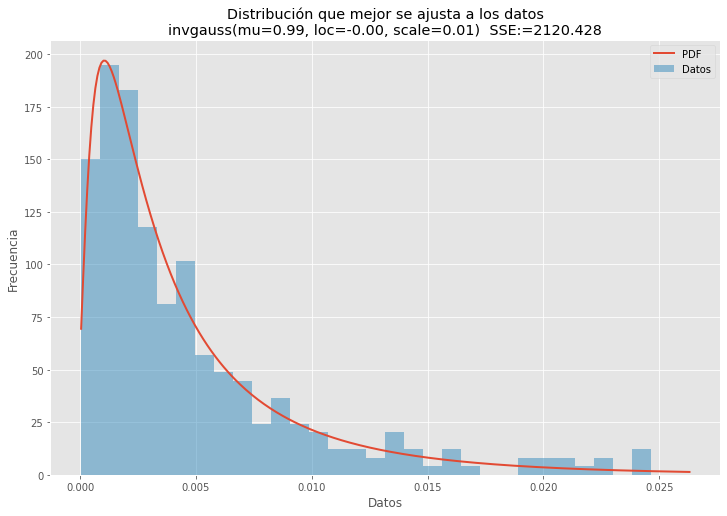

In [56]:
best_pdf(df['col1'], 30, parallel=True)